In [1]:
import os 

os.chdir('C:/Users/rfuchs/Documents/GitHub/M1DGMM')

from copy import deepcopy

from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder

import pandas as pd

from gower import gower_matrix
from sklearn.metrics import silhouette_score


from MIAMI import miami
from init_params import dim_reduce_init
from metrics import misc
from data_preprocessing import gen_categ_as_bin_dataset, \
        compute_nj


import autograd.numpy as np
from autograd.numpy.random import uniform

In [2]:
###############################################################################
###############         Heart    vizualisation          #######################
###############################################################################

#===========================================#
# Importing data
#===========================================#
os.chdir('C:/Users/rfuchs/Documents/These/Stats/mixed_dgmm/datasets')

heart = pd.read_csv('heart_statlog/heart.csv', sep = ' ', header = None)
y = heart.iloc[:,:-1]
labels = heart.iloc[:,-1]
labels = np.where(labels == 1, 0, labels)
labels = np.where(labels == 2, 1, labels)

y = y.infer_objects()
numobs = len(y)

# Too many zeros for this "continuous variable". Add a little noise to avoid 
# the correlation matrix for each group to blow up
uniform_draws = uniform(0, 1E-12, numobs)
y.iloc[:, 9] = np.where(y[9] == 0, uniform_draws, y[9])

n_clusters = len(np.unique(labels))
p = y.shape[1]


In [3]:
#===========================================#
# Formating the data
#===========================================#
var_distrib = np.array(['continuous', 'bernoulli', 'categorical', 'continuous',\
                        'continuous', 'bernoulli', 'categorical', 'continuous',\
                        'bernoulli', 'continuous', 'ordinal', 'ordinal',\
                        'categorical']) 
    
# Ordinal data already encoded
 
y_categ_non_enc = deepcopy(y)
vd_categ_non_enc = deepcopy(var_distrib)

# Encode categorical datas
le = LabelEncoder()
for col_idx, colname in enumerate(y.columns):
    if var_distrib[col_idx] == 'categorical': 
        y[colname] = le.fit_transform(y[colname])

# Encode binary data
le = LabelEncoder()
for col_idx, colname in enumerate(y.columns):
    if var_distrib[col_idx] == 'bernoulli': 
        y[colname] = le.fit_transform(y[colname])
    
enc = OneHotEncoder(sparse = False, drop = 'first')
labels_oh = enc.fit_transform(np.array(labels).reshape(-1,1)).flatten()

nj, nj_bin, nj_ord, nj_categ = compute_nj(y, var_distrib)
y_np = y.values
nb_cont = np.sum(var_distrib == 'continuous')

p_new = y.shape[1]


# Feature category (cf)
cf_non_enc = np.logical_or(vd_categ_non_enc == 'categorical', vd_categ_non_enc == 'bernoulli')

# Non encoded version of the dataset:
y_nenc_typed = y_categ_non_enc.astype(np.object)
y_np_nenc = y_nenc_typed.values

# Defining distances over the non encoded features
dm = gower_matrix(y_nenc_typed, cat_features = cf_non_enc) 

dtype = {y.columns[j]: np.float64 if (var_distrib[j] != 'bernoulli') and \
        (var_distrib[j] != 'categorical') else np.str for j in range(p_new)}

y = y.astype(dtype, copy=True)

In [4]:
#===========================================#
# Defining hyperparameters
#===========================================# 

r = np.array([3, 1])
numobs = len(y)
k = [n_clusters]

seed = 1
init_seed = 2
    
eps = 1E-05
it = 50
maxstep = 100

In [ ]:
#===========================================#
# Defining acceptance rule
#===========================================# 

The user specifies a range for each variable to lie in: \[min\_value, max\_value\].\
An observation is accepted if all of its variables lie in the specified range.\
A set of ranges is called a rule.\
Several rules can be specified in order to select different areas in the observations space.\
To select a particular value for a non-continuous variable (let's say 0), the range is set at \[0,0\]. \
Example of rule for 3 variables, with the first 2 variables that are continuous, and a categorical variable:\
\[-1.3, 2.5\], \[-5.1, 5.1\], \[0,0\]\
Observations with variable 1 in \[-1.3, 2.5\], with variable 2 in \[-5.1, 5.1\] and with variable 3 taking modality \[0,0\] are selected. \
If one wants observations that can take more than one modality for the categorical variable, let's say 0 and 2, one can specify the following second rule: \
\[-1.3, 2.5\], \[-5.1, 5.1\], \[3,3\]. \
The two rules \[-1.3, 2.5\], \[-5.1, 5.1\], \[0,0\] and \[-1.3, 2.5\], \[-5.1, 5.1\], \[3,3\] are passed to MIAMI to properly select the observations. 

In [5]:
num_rules = 5
# The rules are stacked together in a numpy array of shape (2, number of rules, number of variables in the dataset).

# Specify 4 impossible rules: All observations have to be equal to 0 and a very permissive rule, all observations
# required to be in [-10000, 10000] to test the algorithm

authorized_ranges = np.empty((2, num_rules, p_new))
authorized_ranges[0] = 0
authorized_ranges[1] = 0

authorized_ranges[0,0] = -10000
authorized_ranges[1,0] = 10000

target_nb_pseudo_obs = 500

In [6]:
#===========================================#
# Running the algorithm
#===========================================# 

import matplotlib .pyplot as plt
prince_init = dim_reduce_init(y, n_clusters, k, r, nj, var_distrib, seed = None,\
                              use_famd=True)
out = miami(y_np, n_clusters, r, k, prince_init, var_distrib, nj, authorized_ranges,\
            target_nb_pseudo_obs, it, eps, maxstep, seed, perform_selec = False)

0
[-3527.350312558943]
1
[-3527.350312558943, -3494.2783579420393]
2
[-3527.350312558943, -3494.2783579420393, -3488.103158087969]
3
[-3527.350312558943, -3494.2783579420393, -3488.103158087969, -3468.711538639114]
4
[-3527.350312558943, -3494.2783579420393, -3488.103158087969, -3468.711538639114, -3467.064254697816]
5
[-3527.350312558943, -3494.2783579420393, -3488.103158087969, -3468.711538639114, -3467.064254697816, -3464.2390609269255]
6
[-3527.350312558943, -3494.2783579420393, -3488.103158087969, -3468.711538639114, -3467.064254697816, -3464.2390609269255, -3463.6173028883454]
7
[-3527.350312558943, -3494.2783579420393, -3488.103158087969, -3468.711538639114, -3467.064254697816, -3464.2390609269255, -3463.6173028883454, -3466.854975981989]
8
[-3527.350312558943, -3494.2783579420393, -3488.103158087969, -3468.711538639114, -3467.064254697816, -3464.2390609269255, -3463.6173028883454, -3466.854975981989, -3466.5504112053186]
9
[-3527.350312558943, -3494.2783579420393, -3488.1031580

In [7]:
# Plotting utilities
varnames = ['age', 'sex', 'chest pain type', 'resting blood pressure',\
            'serum cholesterol in mg/dl', 'fasting blood sugar > 120 mg/dl',\
            'resting electrocardiographic results', 'maximum heart rate achieved',\
            'exercise induced angina', 'ST depression induced by exercise relative to rest',\
            'the slope of the peak exercise ST segment',\
            'number of major vessels (0-3)', 'thal']

y_new = out['y'][len(y):]

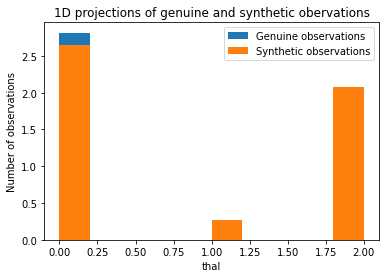

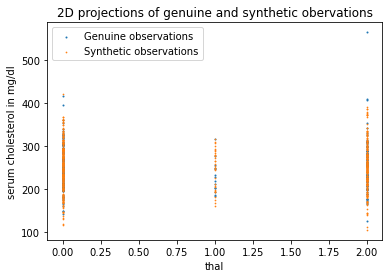

In [8]:
#===========================================#
# Visualisation of the resultts
#===========================================# 

# Choose the variables number
var1 = -1
var2 = 4


# Check for 1D distribution
plt.hist(y_np[:,var1], density = True)
plt.hist(y_new[:,var1], density = True)
plt.xlabel(varnames[var1])
plt.ylabel('Number of observations')
plt.legend(['Genuine observations', 'Synthetic observations'])
plt.title('1D projections of genuine and synthetic obervations')
plt.show()


# Check for 2D distribution
plt.scatter(y_np[:,var1], y_np[:,var2],  label = 'Genuine observations', s = 1)
plt.scatter(y_new[:,var1], y_new[:,var2], label = 'Synthetic observations', s = 0.5)
plt.xlabel(varnames[var1])
plt.ylabel(varnames[var2])
plt.legend(['Genuine observations', 'Synthetic observations'])
plt.title('2D projections of genuine and synthetic obervations')
plt.show()
